# Frame the Problem and Look at the Big Picture 

1. Define the objective in business terms.
- The objective is to predict which squirrels are 
   sick and which are healthy.<!-- (I think confirm this derek) -->-
- our client is part of the Squirrel census and is interested in the health of the squirrels in Central Park.
- The goal is to predict weather or not a squirrel has a certain disease or not.
2. How will your solution be used?
- The solution will be used to predict the health of the squirrels in Central Park. This could save time and money for the Squirrel census.
3. What are the current solutions/workarounds (if any)?
- The current solution is to send out a team of experts to check the health of the squirrels.
- This is time consuming and expensive, and the team can only check a limited number of squirrels.
4. How should you frame this problem (supervised/unsupervised, online/offline, etc.)?
- This is a supervised learning problem because we have labeled data, and it is to be trained on an online capable system.
5. How should performance be measured?
- The performance should be measured using the F1 score, as we want to have a balance between precision and recall.\
6. What would be the minimum performance needed to reach the business objective?
- The minimum performance needed to reach the business objective is an F1 score of ???
7. What are comparable problems? Can you reuse experience or tools?
- This is a classification problem, and we can use the tools and experience from other classification problems. Data from previous experiences might be used in addition to the tools.
8. Is human expertise available?
- Yes, human expertise is availabe. Our client is part of the Squirrel census and has a lot of knowledge about the health of the squirrels in Central Park.
9. How would you solve the problem manually?
- The problem could be solved manually by sending out a team of experts to check the health of the squirrels.
10. List the assumptions you (or others) have made so far.
- The data is accurate and up to date.
- The data is labeled correctly.


# Get the Data

1. List the data you need and how much you need.
   - We will need the diseased squirrel data which was provided by the client and the 2018 squirrel census data, along with weather data that is realevent to the target area. 
2. Find and document where you can get that data.
    - The data was obtained from the [NYC OpenData Collections](https://data.cityofnewyork.us/Environment/2018-Central-Park-Squirrel-Census-Squirrel-Data/vfnx-vebw/about_data), [Weather Data](https://www.ncei.noaa.gov/data/daily-summaries/doc/GHCND_documentation.pdf)  and obtained from the client.
    
3. Get access authorizations.
    - N/A
4. Create a workspace (with enough storage space).
    - N/A
5. Get the data.
    - N/A
6. Convert the data to a format you can easily manipulate (without changing the data itself).
    - The data is in three separate CSV files. We will load the data into a pandas DataFrame, and combine the data into a single DataFrame. (to be easily manipulated)
7. Ensure sensitive information is deleted or protected (e.g. anonymized).
    - N/A
8. Check the size and type of data (time series, sample, geographical, etc.).
    - The data is sample data and includes location data for each of the squirrels. 
9. Sample a test set, put it aside, and never look at it (no data snooping!).
    - We will sample 10% of the data and put it aside.

In [26]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from pandas.tseries.offsets import MonthEnd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

from sklearn import set_config
set_config(transform_output = "pandas")

In [27]:
def load_data(census_data="2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20241105.csv",ad_viz_data="ad_viz_plotval_data.csv",
              co2air_data="co2air.csv", disease_data="diseased_squirrels.csv", no2_data="NO2.csv", pbair_data="Pbair.csv",
              weather_data="weather.csv"):
    
    #load the data
    census = pd.read_csv(census_data)
    ad_viz = pd.read_csv(ad_viz_data)
    co2air = pd.read_csv(co2air_data)
    disease = pd.read_csv(disease_data,header=None)
    no2 = pd.read_csv(no2_data)
    pbair = pd.read_csv(pbair_data)
    weather = pd.read_csv(weather_data)

    return census, ad_viz, co2air, disease, no2, pbair, weather

load_data()


(              X          Y Unique Squirrel ID Hectare Shift      Date  \
 0    -73.956134  40.794082     37F-PM-1014-03     37F    PM  10142018   
 1    -73.968857  40.783783     21B-AM-1019-04     21B    AM  10192018   
 2    -73.974281  40.775534     11B-PM-1014-08     11B    PM  10142018   
 3    -73.959641  40.790313     32E-PM-1017-14     32E    PM  10172018   
 4    -73.970268  40.776213     13E-AM-1017-05     13E    AM  10172018   
 ...         ...        ...                ...     ...   ...       ...   
 3018 -73.963943  40.790868     30B-AM-1007-04     30B    AM  10072018   
 3019 -73.970402  40.782560     19A-PM-1013-05     19A    PM  10132018   
 3020 -73.966587  40.783678     22D-PM-1012-07     22D    PM  10122018   
 3021 -73.963994  40.789915     29B-PM-1010-02     29B    PM  10102018   
 3022 -73.975479  40.769640      5E-PM-1012-01     05E    PM  10122018   
 
       Hectare Squirrel Number    Age Primary Fur Color  \
 0                           3    NaN              

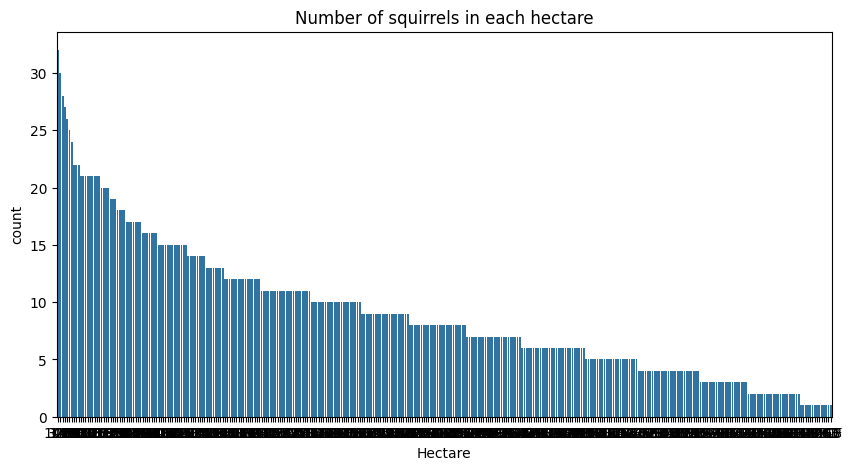

In [28]:

# Load the data
census, ad_viz, co2air, disease, no2, pbair, weather = load_data()

#plot of the number of squirrels in each hectare
def plot_squirrel_density(census):
    #plot the number of squirrels in each hectare
    plt.figure(figsize=(10,5))
    sns.countplot(x='Hectare', data=census, order=census['Hectare'].value_counts().index)
    plt.title('Number of squirrels in each hectare')
    plt.show()


plot_squirrel_density(census)
    

In [29]:
percent_missing = census.isnull().mean() * 100
missing_value_df = pd.DataFrame({'column_name': census.columns,
                                 'percent_missing': percent_missing})

print(missing_value_df)


                                                                           column_name  \
X                                                                                    X   
Y                                                                                    Y   
Unique Squirrel ID                                                  Unique Squirrel ID   
Hectare                                                                        Hectare   
Shift                                                                            Shift   
Date                                                                              Date   
Hectare Squirrel Number                                        Hectare Squirrel Number   
Age                                                                                Age   
Primary Fur Color                                                    Primary Fur Color   
Highlight Fur Color                                                Highlight Fur Color   
Combinatio

---
Going through the census data we have found that there is a large percentage of missing values in the columns for :
* Color notes 
* Specific Location    
* Other Activities
* Other Interactions  
* Highlight Fur Color 

These columns have 80-90% missing values  with highlight fur color having the lowest ammount with 35% missing values. The location, activites, and interactions are all what the recorders observed and will not be in a format that can be easily usable without modification. It is possible to use a vector search and see if there are any correlations based on the language used but this will not be used as a primary focus for finding corelations at the moment. 

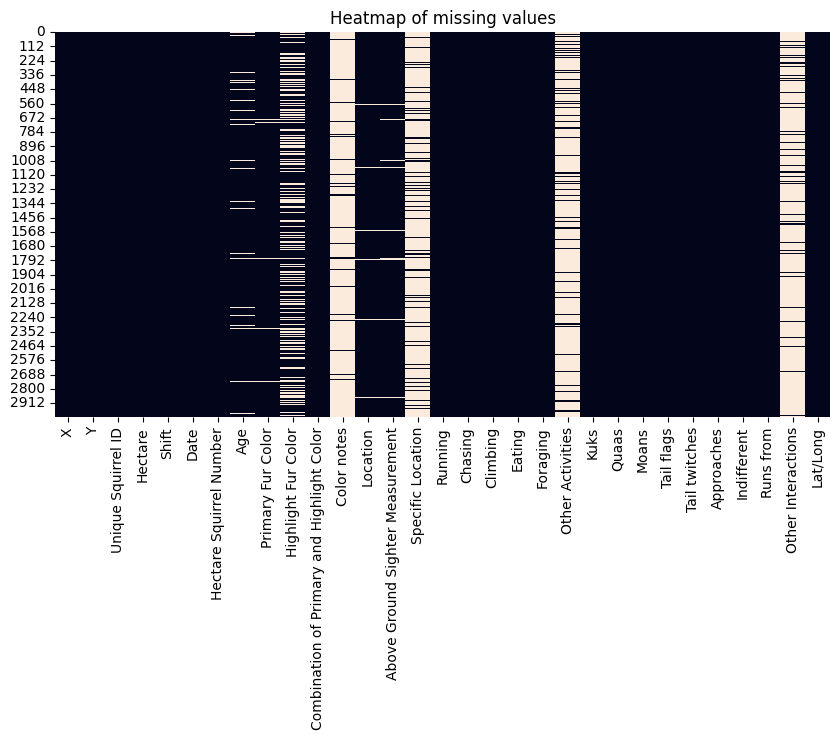

In [30]:
#heatmap of missing values
plt.figure(figsize=(10,5))
sns.heatmap(census.isnull(), cbar=False)
plt.title('Heatmap of missing values')
plt.show()


In [31]:
#create a list of unique values in other activities and other interactions 
other_activities = census['Other Activities'].unique()
other_interactions = census['Other Interactions'].unique()

# print the unique values in other activities and other interactions
print(other_activities)
print(other_interactions)


[nan 'grooming' 'walking' 'moving slowly' 'sitting'
 'eating (ate upside down on a tree — #jealous)' 'wrestling with mother'
 'running (with nut)' 'playing with #5' 'hiding nut'
 'drank from a pond of rain water' 'chasing (#4 across trees)'
 'gathering acorns'
 'eating (a mushroom),circles around us,really fat,scratching himself,grooming activity'
 'digging' 'walking on branch' 'being chased,was pushed by other squirrel'
 'climbing (tree)' 'chasing #8' 'still' 'stop to look at me—then ran'
 'chasing (a chipmunk)' 'took nut to bury' 'flying'
 'stole (found?) an entire sandwich' 'walking w/ something in mouth'
 'burying nut' 'begging' 'was hanging out w/ #2 until i showed up'
 'quietly' 'nest building' 'burying' 'dead (something ran over it)'
 'chased #12' 'playing (with #9)' 'sitting still' 'posing'
 'sitting in tree' 'together w/ #7' 'not sure walk-pause-walk' 'jumping'
 'eating (mushroom)'
 'eating (eats with head tilted far to the right (tooth issue?))'
 'playing tag together' 'pranc

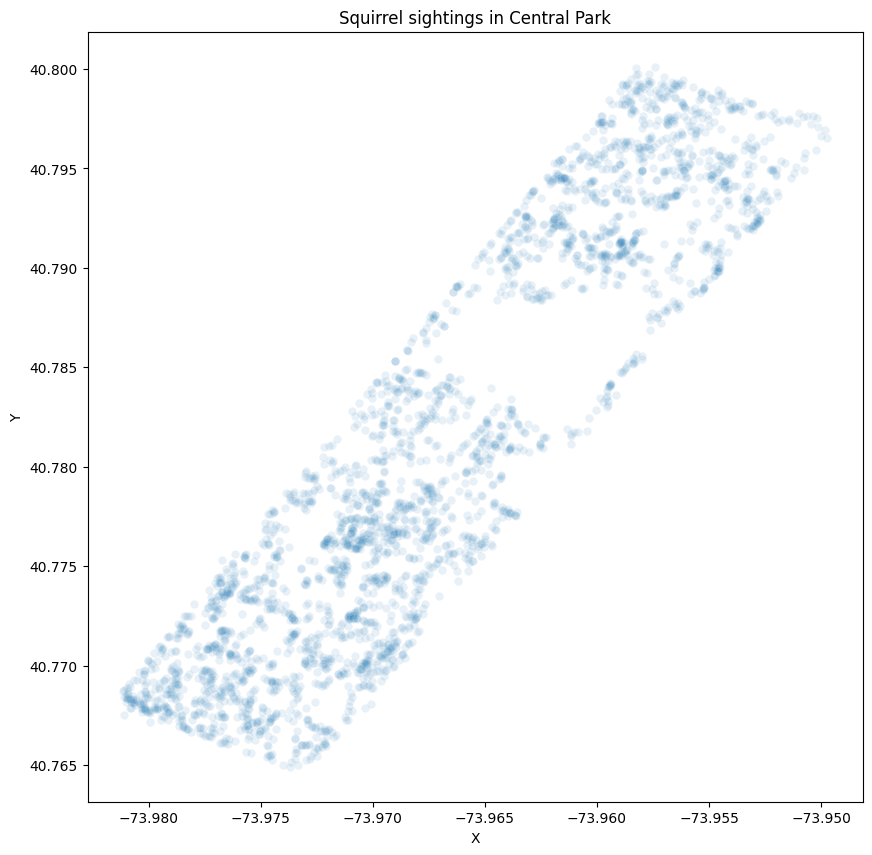

In [32]:
# map of the squirrel sightings with alpha to show density
def plot_squirrel_map(census):
    plt.figure(figsize=(10,10))
    sns.scatterplot(x='X', y='Y', data=census, alpha=0.1)
    plt.title('Squirrel sightings in Central Park')
    plt.show()

plot_squirrel_map(census)

    



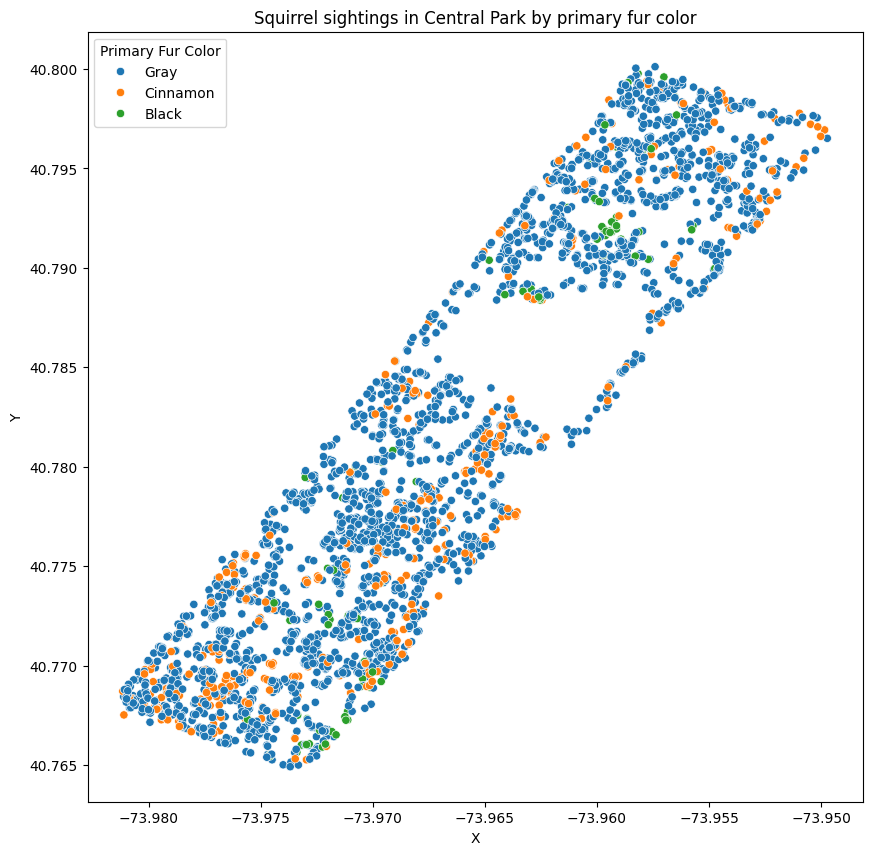

In [33]:
# plot all the sightings of squirrels in the park and color by the primary fur color
def plot_squirrel_fur_color(census):
    plt.figure(figsize=(10,10))
    sns.scatterplot(x='X', y='Y', data=census, hue='Primary Fur Color')
    plt.title('Squirrel sightings in Central Park by primary fur color')
    plt.show()

plot_squirrel_fur_color(census)

In [34]:
# Load your data
census, ad_viz, co2air, disease, no2, pbair, weather = load_data()

# Clean disease data (list of IDs)
diseased_ids = disease[0].tolist()

# Create a 'Diseased' column in the census data
census['Diseased'] = census['Unique Squirrel ID'].isin(diseased_ids)


In [35]:
# Compare age distribution
age_counts = census.groupby(['Age', 'Diseased']).size().unstack()
print(age_counts)

# Chi-squared test for fur color

fur_color_table = pd.crosstab(census['Primary Fur Color'], census['Diseased'])
chi2, p, dof, ex = chi2_contingency(fur_color_table)
print(f"P-value for fur color difference: {p}")


Diseased   False  True 
Age                    
?            4.0    NaN
Adult     2273.0  295.0
Juvenile   311.0   19.0
P-value for fur color difference: 5.944483338009056e-248


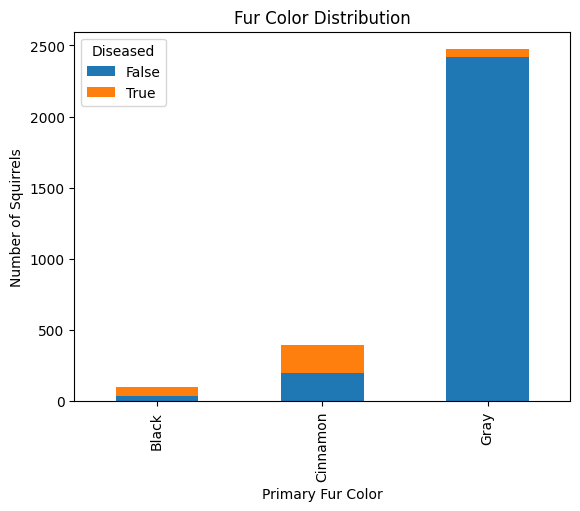

In [36]:
# Bar chart for fur color
fur_color_counts = census.groupby(['Primary Fur Color', 'Diseased']).size().unstack()
fur_color_counts.plot(kind='bar', stacked=True)
plt.title('Fur Color Distribution')
plt.xlabel('Primary Fur Color')
plt.ylabel('Number of Squirrels')
plt.show()


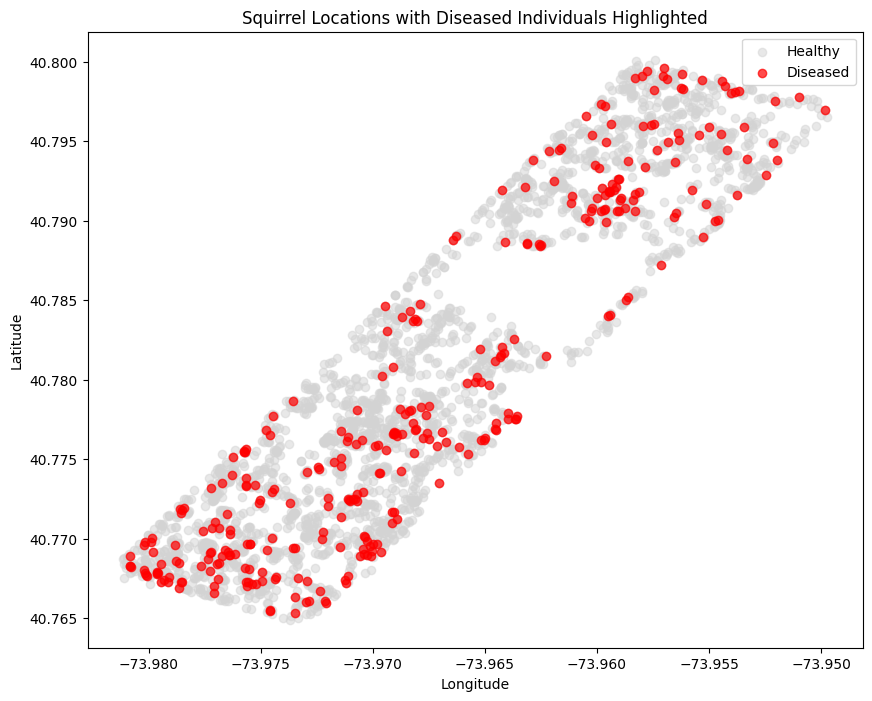

In [37]:
# Plot all squirrels
plt.figure(figsize=(10, 8))
plt.scatter(census['X'], census['Y'], c='lightgrey', label='Healthy', alpha=0.5)

# Highlight diseased squirrels
diseased_squirrels = census[census['Diseased']]
plt.scatter(diseased_squirrels['X'], diseased_squirrels['Y'], c='red', label='Diseased', alpha=0.7)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Squirrel Locations with Diseased Individuals Highlighted')
plt.legend()
plt.show()


/var/folders/58/v989862n3fgbk7qszg37rj8m0000gp/T/ipykernel_51544/3437729056.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=diseased_squirrels['X'], y=diseased_squirrels['Y'], cmap="Reds", shade=True, bw_adjust=.5)


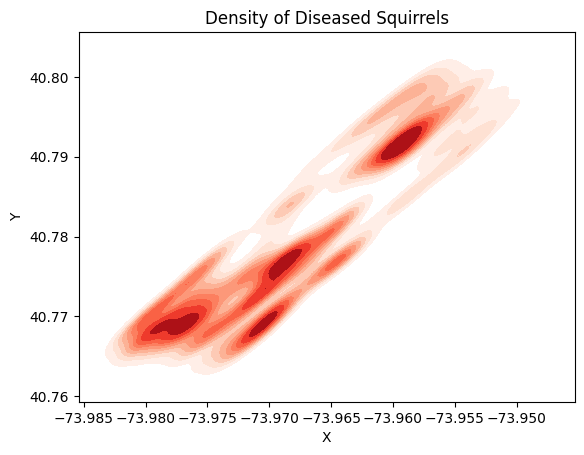

In [38]:
# Density Estimation plot for diseased squirrels
sns.kdeplot(x=diseased_squirrels['X'], y=diseased_squirrels['Y'], cmap="Reds", shade=True, bw_adjust=.5)
plt.title('Density of Diseased Squirrels')
plt.show()


In [39]:
# plot the percentage of squirrels that are diseased and not diseased by behavior
behaviors = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging']









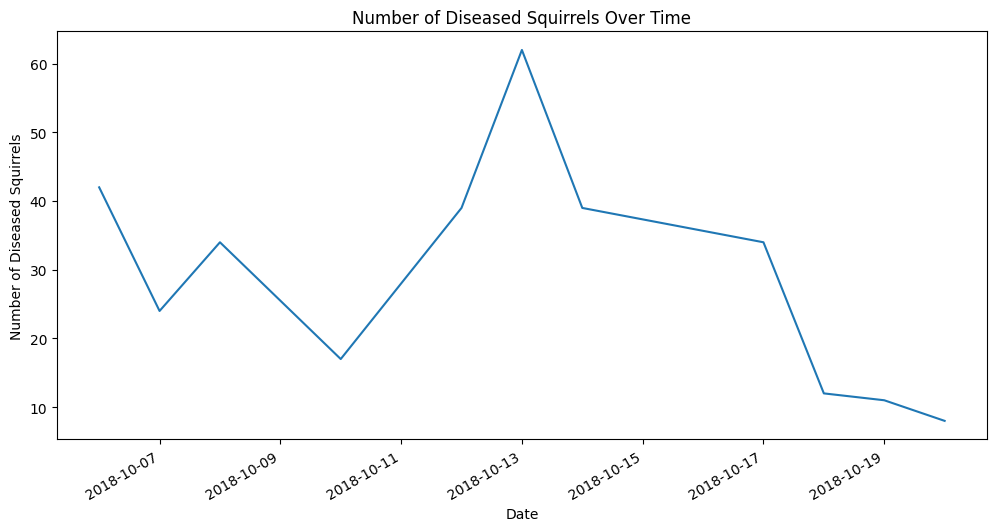

In [40]:
census['Date'] = pd.to_datetime(census['Date'], format='%m%d%Y')

# Time series plot
census.set_index('Date', inplace=True)
disease_time_series = census.groupby('Date')['Diseased'].sum()

plt.figure(figsize=(12, 6))
disease_time_series.plot()
plt.title('Number of Diseased Squirrels Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Diseased Squirrels')
plt.show()


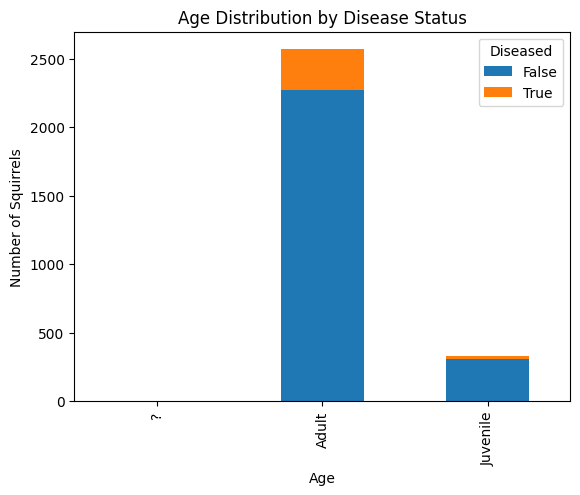

In [41]:
age_counts = census.groupby(['Age', 'Diseased']).size().unstack()
age_counts.plot(kind='bar', stacked=True)
plt.title('Age Distribution by Disease Status')
plt.xlabel('Age')
plt.ylabel('Number of Squirrels')
plt.show()


In [42]:
# find the percentage of dieased squirrels with Other Activities, and Other Interactions and list the 
# activities and interactions where diseased squirrels are more than 50% of the total number of squirrels

# Percentage of diseased squirrels with Other Activities
other_activities_counts = census.groupby(['Other Activities', 'Diseased']).size().unstack()
other_activities_counts['Percentage Diseased'] = other_activities_counts[True] / other_activities_counts.sum(axis=1)
print(other_activities_counts)

# Percentage of diseased squirrels with Other Interactions
other_interactions_counts = census.groupby(['Other Interactions', 'Diseased']).size().unstack()
other_interactions_counts['Percentage Diseased'] = other_interactions_counts[True] / other_interactions_counts.sum(axis=1)
print(other_interactions_counts)

# Activities where diseased squirrels are more than 50% of the total number of squirrels
activities_over_50 = other_activities_counts[other_activities_counts['Percentage Diseased'] > 0.5]
print(activities_over_50)

# Interactions where diseased squirrels are more than 50% of the total number of squirrels
interactions_over_50 = other_interactions_counts[other_interactions_counts['Percentage Diseased'] > 0.5]
print(interactions_over_50)





Diseased                                False  True  Percentage Diseased
Other Activities                                                        
#7 & #8 chased each other up diff tree    1.0   NaN                  NaN
2/3 chasing each other                    2.0   NaN                  NaN
2/3 were chasing each other               2.0   NaN                  NaN
a lot of activity                         1.0   NaN                  NaN
acorns                                    1.0   NaN                  NaN
...                                       ...   ...                  ...
watching passers-by                       1.0   NaN                  NaN
with some nuts in the mouth               1.0   NaN                  NaN
wresting w/ branch                        1.0   NaN                  NaN
wrestling with child                      NaN   1.0                  1.0
wrestling with mother                     1.0   NaN                  NaN

[307 rows x 3 columns]
Diseased                   

---
To see if there could be a correlation between the 

In [43]:
print(weather.head())

       STATION                         NAME  LATITUDE  LONGITUDE  ELEVATION  \
0  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
1  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
2  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
3  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   
4  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925       42.7   

         DATE  AWND AWND_ATTRIBUTES    FMTM FMTM_ATTRIBUTES  ...  WT16  \
0  2010-12-31  6.04             ,,W  2124.0             ,,X  ...   NaN   
1  2011-01-01  3.13             ,,W     1.0             ,,X  ...   NaN   
2  2011-01-02  5.14             ,,W  2232.0             ,,X  ...   1.0   
3  2011-01-03  8.72             ,,W   222.0             ,,X  ...   NaN   
4  2011-01-04  6.26             ,,W  1715.0             ,,X  ...   NaN   

  WT16_ATTRIBUTES  WT17 WT17_ATTRIBUTES  WT18 WT18_ATTRIBUTES  WT19  \
0        

In [44]:
# Reset index to access 'Date' column
census.reset_index(inplace=True)

# Convert date column in census and weather data to datetime
census['Date'] = pd.to_datetime(census['Date'], format='%m%d%Y')
weather['DATE'] = pd.to_datetime(weather['DATE'], format='%Y-%m-%d')

# Merge the census and weather data on the date column
census_weather = pd.merge(census, weather, left_on='Date', right_on='DATE', how='inner')

# Align date range to census data
census_weather = census_weather[(census_weather['Date'] >= '2018-10-01') & (census_weather['Date'] <= '2018-10-31')]

print(census_weather.head())


        Date          X          Y Unique Squirrel ID Hectare Shift  \
0 2018-10-14 -73.956134  40.794082     37F-PM-1014-03     37F    PM   
1 2018-10-19 -73.968857  40.783783     21B-AM-1019-04     21B    AM   
2 2018-10-14 -73.974281  40.775534     11B-PM-1014-08     11B    PM   
3 2018-10-17 -73.959641  40.790313     32E-PM-1017-14     32E    PM   
4 2018-10-17 -73.970268  40.776213     13E-AM-1017-05     13E    AM   

   Hectare Squirrel Number    Age Primary Fur Color Highlight Fur Color  ...  \
0                        3    NaN               NaN                 NaN  ...   
1                        4    NaN               NaN                 NaN  ...   
2                        8    NaN              Gray                 NaN  ...   
3                       14  Adult              Gray                 NaN  ...   
4                        5  Adult              Gray            Cinnamon  ...   

  WT16 WT16_ATTRIBUTES WT17 WT17_ATTRIBUTES WT18  WT18_ATTRIBUTES  WT19  \
0  NaN           

In [45]:
#create a correlation matrix of the census_weather data and plot a heatmap of the correlation matrix

#select only the numeric columns
census_weather_numeric = census_weather.select_dtypes(include=[np.number])




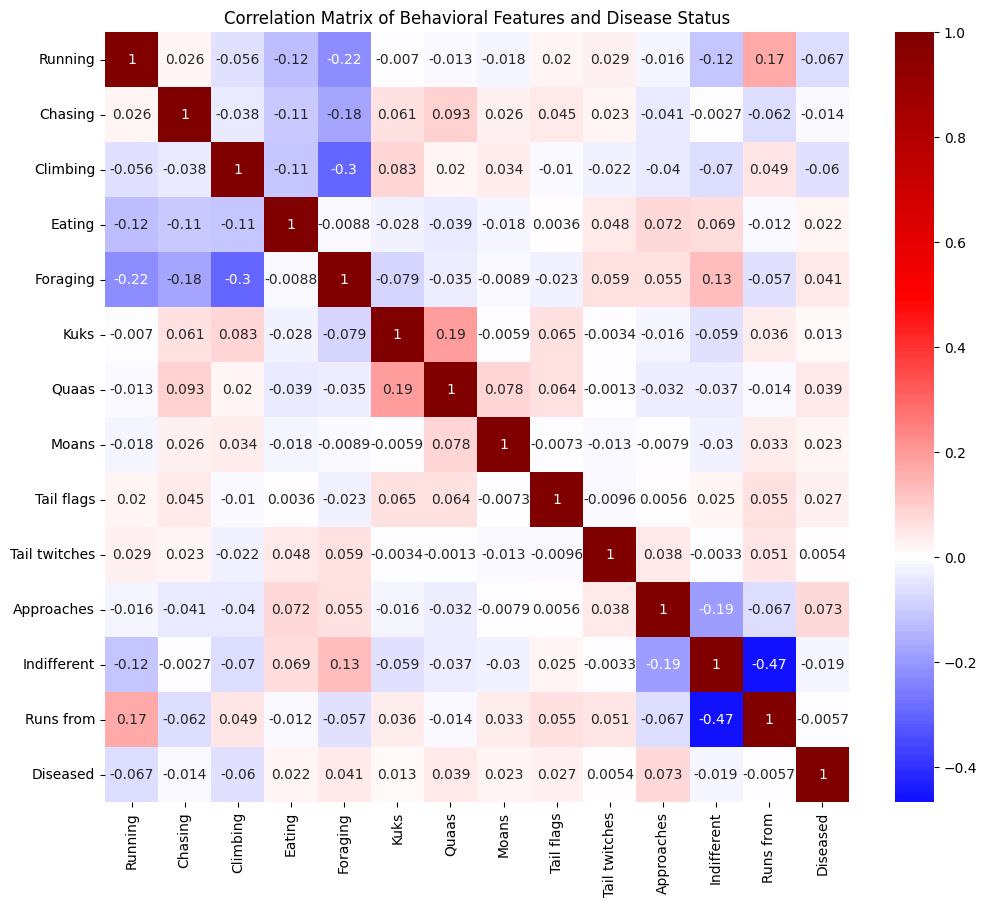

In [46]:
# correlation matrix of behavioral features and the 'Diseased' column

#select only the behavioral features and the 'Diseased' column

behavioral_features = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging','Kuks','Quaas','Moans','Tail flags','Tail twitches','Approaches','Indifferent','Runs from']

behavioral_features_diseased = census_weather[behavioral_features + ['Diseased']]
behavioral_features_diseased = behavioral_features_diseased.dropna()

correlation_matrix = behavioral_features_diseased.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='seismic', center=0)
plt.title('Correlation Matrix of Behavioral Features and Disease Status')
plt.show()


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Replace NaN values with an empty string
census_weather['Other Activities'] = census_weather['Other Activities'].fillna("")
census_weather['Other Interactions'] = census_weather['Other Interactions'].fillna("")
census_weather['Specific Location'] = census_weather['Specific Location'].fillna("")


# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit and transform the vectorizer on the 'Other Activities' column
other_activities_tfid = vectorizer.fit_transform(census_weather['Other Activities'])

other_interactions_tfid = vectorizer.fit_transform(census_weather['Other Interactions'])

specific_location_tfid = vectorizer.fit_transform(census_weather['Specific Location'])

In [49]:
# Combine the 'Age' and 'Primary Fur Color' columns to create a stratification group
census_weather['Stratify_Group'] = census_weather['Age'].astype(str) + "_" +\
      census_weather['Primary Fur Color'].astype(str)

# Define X and y
X = census_weather.drop(['Diseased', 'Stratify_Group'], axis=1)
y = census_weather['Diseased']

# Split the data with stratification on the combined group
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                    random_state=42, stratify=census_weather['Stratify_Group'])

In [50]:
#drop columns that have 100% missing values
census_weather = census_weather.dropna(axis=1, how='all')

In [56]:
# function to drop specific features from the data 
def drop_features(data, features_to_drop):
    return data.drop(features_to_drop, axis=1)

# list of features to drop
features_to_drop = ['X', 'Y', 'Shift', 'STATION','NAME','LATITUDE','LONGITUDE',
                    'ELEVATION','PRCP_ATTRIBUTES','SNOW','SNOW_ATTRIBUTES','SNWD'
                    ,'SNWD_ATTRIBUTES','TMAX_ATTRIBUTES','TMIN_ATTRIBUTES','WT01','WT01_ATTRIBUTES',
                    'AWND_ATTRIBUTES','PRCP_ATTRIBUTES','WDF2_ATTRIBUTES', 'WDF5_ATTRIBUTES',
                    'WSF2_ATTRIBUTES', 'WSF5_ATTRIBUTES','WT08', 'WT08_ATTRIBUTES'  ]



In [61]:
data["Above Ground Sighter Measurement"]

0         NaN
1         NaN
2          10
3         NaN
4         NaN
        ...  
3018    FALSE
3019    FALSE
3020    FALSE
3021    FALSE
3022    FALSE
Name: Above Ground Sighter Measurement, Length: 3023, dtype: object

In [64]:
#Pipeline 
#drop features_to_drop
data = drop_features(census_weather, features_to_drop)
numeric_features = data.select_dtypes(include=[np.number]).columns.to_list()
numeric_features.append('Above Ground Sighter Measurement')
numeric_features.append('Lat/Long')
# print(numeric_features)
#categorical features are the features that are not numeric
category_features = data.columns.difference(numeric_features)
print(category_features)

# Define the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), category_features)
    ])
 

Index(['Age', 'Approaches', 'Chasing', 'Climbing', 'Color notes',
       'Combination of Primary and Highlight Color', 'DATE', 'Date',
       'Diseased', 'Eating', 'Foraging', 'Hectare', 'Highlight Fur Color',
       'Indifferent', 'Kuks', 'Lat/Long', 'Location', 'Moans',
       'Other Activities', 'Other Interactions', 'Primary Fur Color', 'Quaas',
       'Running', 'Runs from', 'Specific Location', 'Stratify_Group',
       'Tail flags', 'Tail twitches', 'Unique Squirrel ID'],
      dtype='object')
